In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import requests as re

sns.set_context('poster')
sns.set_style('whitegrid')


from sklearn.tree import export_graphviz


#Trees
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#Preprocessing packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer #One hot encoding
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Metrics
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus 
from IPython.display import Image 

#Bootstrap
from sklearn.utils import resample

%matplotlib inline


In [3]:
df = pd.read_json('train_data.json')
test = pd.read_json('test_data.json')

@BRADEN @BRIANNA do we need to set index as the row labels on the dataframe?

#todo What do you mean by this? 
What is the index column? Like should those be our row labels because the row labels are currently 0, 100, 1000... they seem random

In [ ]:
df.interest_level.value_counts()

In [ ]:
test = pd.read_json('test_data.json')

In [ ]:
test.info()

In [ ]:
# Pairwise Plot of Data
sns.pairplot(df)

In [4]:
def interestValues(x):
    if 'low' in x:
        return 0
    elif 'med' in x:
        return .5
    else:
        return 1

In [ ]:
df['interestVal'] = df['interest_level'].apply(interestValues)

In [ ]:
df.interest_level.value_counts()

In [ ]:
df.interestVal.value_counts()

In [ ]:
cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(df, x_vars=['interestVal'], y_vars=cols)
plt.savefig('interestLevelPairwise.png')

In [ ]:
# Correlation Matrix of Data
sns.heatmap(df.corr())

In [ ]:
# Side by Side Box Plot of log(Price) vs. High, Medium, and Low Interest
sns.boxplot(x=df['interest_level'], y=df['price'].apply(np.log))

In [ ]:
# Side by Side Box Plot of Bathrooms vs. High, Medium, and Low Interest
sns.boxplot(x=df['interest_level'], y=df['bathrooms'])

In [ ]:
df['bedrooms'] = df['bedrooms'].apply(float)
df['bedrooms'].fillna(0, inplace=True)
df['bathrooms'].fillna(0, inplace=True)

In [ ]:
df['studio'] = df['description'].apply(lambda x : 'studio' in x.lower())

In [ ]:
sns.lmplot(col='interest_level',x='bedrooms', y='bathrooms', data=df, ci=None, hue='studio')

In [ ]:
# Side by Side Box Plot of Bedrooms vs. High, Medium, and Low Interest
sns.boxplot(x=df['interest_level'], y=df['bedrooms'])

In [ ]:
# See if geographical location affects interest level
sns.lmplot(x="latitude", y="longitude", hue="interest_level", data=df, fit_reg=False, legend=True, markers='.')

If we drop these two locational outliers and zoom in on the clustered points, maybe we can find something out about location... @Braden @Brianna what is the best way to remove these points?

Those points are plotted at the (lat, long) of (0, -120). This is the standard return of googlemap's api if it cannot find the address due to formatting. Therefore, we should drop them.

In [ ]:
outRem = df[df['latitude'] > 5]
outRem = outRem[outRem['longitude'] > -110]

In [ ]:
sns.lmplot(x='latitude', y='longitude', hue='interest_level', data = outRem, size=10, ci=False)
plt.xlim([40, 41.5])
plt.ylim([-75.0,-72.5])

In [ ]:
sns.lmplot(x='latitude', y='longitude', col='interest_level', data = outRem)

In [ ]:
sns.lmplot(x='latitude', y='longitude', data = outRem[outRem['interest_level']=='high'])

In [ ]:
sns.lmplot(x='latitude', y='longitude', data = outRem[outRem['interest_level']=='medium'])

In [ ]:
sns.lmplot(x='latitude', y='longitude', data = outRem[outRem['interest_level']=='low'])

In [ ]:
# perform variable selection according to recitation!

In [111]:
train = pd.read_json('train_data.json')
train['interest_level_conv'] = train['interest_level'].apply(interestValues)

train, test = train_test_split(train,test_size = .3,random_state = 42)

altered_train = train.drop(['interest_level','interest_level_conv','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'], axis=1)
altered_test = test.drop(['interest_level','interest_level_conv','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'], axis=1)


y_train = train['interest_level']
y_test = test['interest_level']
print("Value Counts: \n {} \n \n".format(test.interest_level.value_counts()))
tree_fit = tree.DecisionTreeClassifier(max_depth=3)
tree_fit.fit(altered_train,y_train)      
print("The test accuracy is: {} \n".format(tree_fit.score(altered_test,y_test)))
print("Confusion Matrix: \n \n Low Medium High \n{}".format(confusion_matrix(tree_fit.predict(altered_test),y_test,labels=['low','medium','high'])))


Value Counts: 
 low       8780
medium    2794
high      1002
Name: interest_level, dtype: int64 
 

The test accuracy is: 0.7013358778625954 

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Confusion Matrix: 
 
 Low Medium High 
[[8734 2750  916]
 [   0    0    0]
 [  46   44   86]]


In [28]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(3) / len(y_test)

low       0.698155
medium    0.222169
high      0.079676
Name: interest_level, dtype: float64

In [23]:
labels = list(altered_train.columns.values)

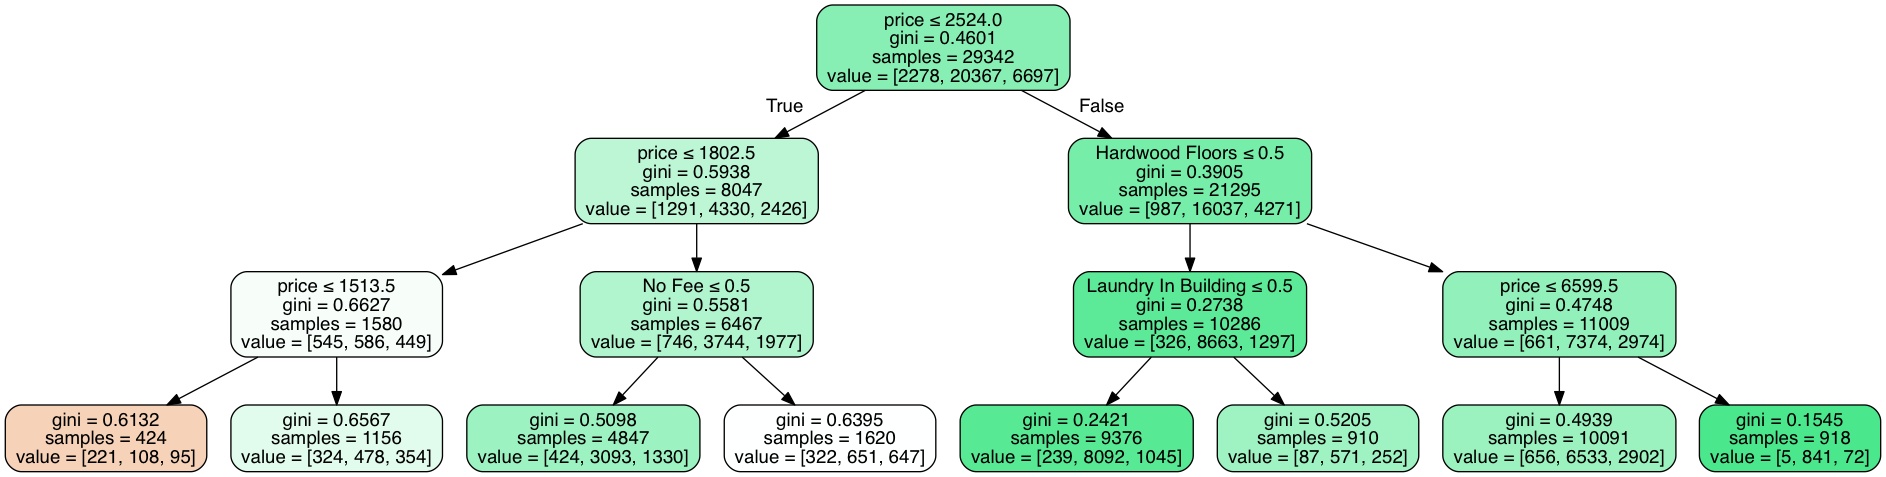

In [31]:
#create a labels = [] Tag
dot_data = tree.export_graphviz(tree_fit, out_file=None, feature_names=labels,
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

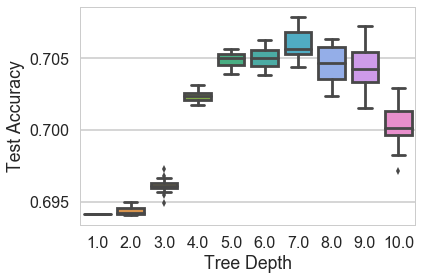

In [8]:
#We perform a 100 try 10fold cross validation
score = np.array([])# Array to store Misclassification Error
depth = np.array([]) # Array to store tree depth
clf = tree.DecisionTreeClassifier() #Define model ot be used
for trial in range(20):
    cv_method = KFold(n_splits=10,shuffle=True) #Define CV method
    for tree_depth in range(1,11,1):
        clf.set_params(max_depth = tree_depth)
        depth = np.append(depth,tree_depth)
        error = np.mean(cross_val_score(clf,altered_train,y_train,cv = cv_method,scoring = 'accuracy')) #Run cross validation
        score = np.append(score,error)
        
sns.boxplot(x = depth,y = score)
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')

In [132]:
#Bagging of trees of depth 7
# Choosing number of trees tested with to 1000, 3000 random samples taken to fit each tree. 
train = pd.read_json('train_data.json')
N = 300
preds = [[] for _ in range(N)]
for sample in range(N):
    altered_train_boot = train.sample(3000,replace=True,random_state=sample)
    train_bootstrap = altered_train_boot.drop(['interest_level','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'],axis=1)
    y_train = altered_train_boot['interest_level']
    tree_fit = tree.DecisionTreeClassifier()
    tree_fit.fit(train_bootstrap,y_train)      
    preds[sample] = tree_fit.predict(altered_test).tolist()


In [131]:
def most_common(lst):
    return max(set(lst), key=lst.count)
rearrange = [[x[y] for x in preds] for y in range(0,12576)]
final_pred = [most_common(x) for x in rearrange]
scoring = [(x,y) for x,y in zip(final_pred,y_test.tolist()) if x==y]
score = len(scoring)/len(final_pred)
print("The bagged tree results in a classification accuracy of {}".format(score))

The bagged tree results in a classification accuracy of 0.7138994910941476


In [ ]:
#First lets explore the number of trees
error_rate_sqrt = np.array([])
num_trees_sqrt = np.array([])

error_rate_bag = np.array([])
num_trees_bag = np.array([])

min_trees = 100
max_trees = 200

clf_sqrt = RandomForestClassifier(warm_start=False, 
                             oob_score=True,
                             max_features="sqrt",
                             random_state = 1)

clf_bagging = RandomForestClassifier(warm_start=False, 
                             oob_score=True,
                             max_features=None,
                             random_state = 1)



for i in range(min_trees,max_trees+1):
    clf_sqrt.set_params(n_estimators=i)
    clf_sqrt.fit(altered_train, y_train)
    error_rate_sqrt = np.append(error_rate_sqrt,clf_sqrt.oob_score_)
    num_trees_sqrt = np.append(num_trees_sqrt,i)
    
    clf_bagging.set_params(n_estimators=i)
    clf_bagging.fit(altered_train, y_train)
    error_rate_bag = np.append(error_rate_bag,clf_bagging.oob_score_)
    num_trees_bag = np.append(num_trees_bag,i)

plt.plot(num_trees_sqrt,error_rate_sqrt);
plt.plot(num_trees_bag,error_rate_bag,c='red');
plt.xlabel('Number of Trees');
plt.ylabel('Accuracy');

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

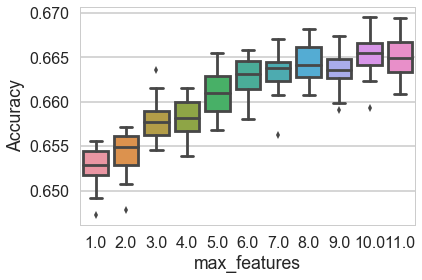

In [9]:
error_rate = np.array([])
num_trees = np.array([])

min_features = 1
max_features = 11


for trial in range(20):
    clf = RandomForestClassifier(oob_score=True,
                             n_estimators=10,
                             random_state = trial)
    for m in range(min_features,max_features+1):
        clf.set_params(max_features=m)
        clf.fit(altered_train, y_train)
        error_rate = np.append(error_rate,clf.oob_score_)
        num_trees = np.append(num_trees,m)

sns.boxplot(x = num_trees,y = error_rate)
plt.xlabel('max_features');
plt.ylabel('Accuracy');

In [13]:
classifier = RandomForestClassifier(oob_score=True, n_estimators=200,
                                    random_state=1, max_features='auto')
classifier.fit(altered_train, y_train)
error = classifier.oob_score_

In [14]:
print(error)

0.712800763411


In [16]:
print(classifier.predict_proba(altered_test))


[[ 0.01   0.845  0.145]
 [ 0.775  0.13   0.095]
 [ 0.105  0.59   0.305]
 ..., 
 [ 0.01   0.96   0.03 ]
 [ 0.125  0.62   0.255]
 [ 0.01   0.53   0.46 ]]


low       0.698155
medium    0.222169
high      0.079676
Name: interest_level, dtype: float64

In [18]:
from sklearn.preprocessing import binarize
